# Demonstrate how to use DensityDist
Utilize a scipy.stats.rayleigh distribution to demonstrate

In [1]:
import pymc3 as pm
import seaborn as sns
import scipy
import scipy.stats
import numpy as np
import spacepy.toolbox as tb
import matplotlib.pyplot as plt
from theano import theano, tensor as tt

sns.set(font_scale=1.5)

## Given example
https://pymc3.readthedocs.io/en/latest/notebooks/normalizing_flows_overview.html?highlight=densitydist

In [2]:
from pymc3.distributions.dist_math import bound

def pot1(z):
    z = z.T
    return .5*((z.norm(2, axis=0)-2.)/.4)**2 - tt.log(tt.exp(-.5*((z[0]-2.)/.6)**2) +
                                                      tt.exp(-.5*((z[0]+2.)/.6)**2))


def cust_logp(z):
    # this works to cut things off, useful or not but 0 is a nature place a lot of times
    return bound(-pot1(z), z>-5, z<5) 
#     return -pot1(z)

with pm.Model() as pot1m:
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    trace = pm.sample(1000)

/tmp/ipykernel_567/6117630.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pot1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/tmp/ipykernel_567/2777670638.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);
Got error No model on context stack. trying to find log_likelihood in translation.
/home/balarsen/miniconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


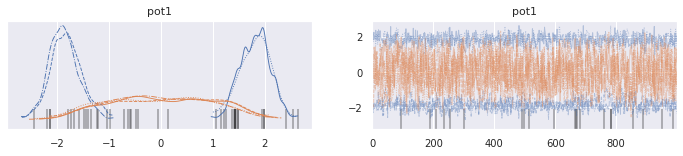

In [3]:
pm.traceplot(trace);

Got error No model on context stack. trying to find log_likelihood in translation.
/home/balarsen/miniconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


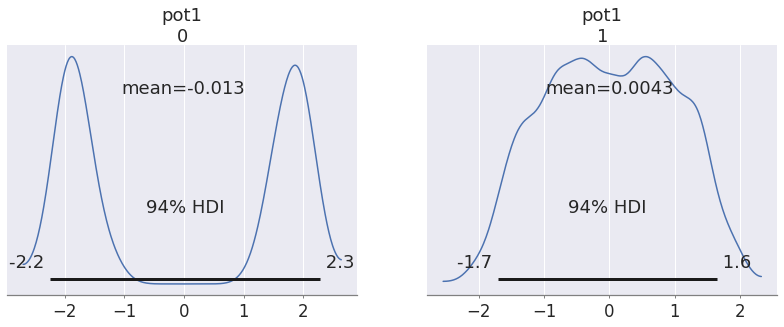

In [4]:
pm.plot_posterior(trace);

## Now can we do this from a histogram?

/home/balarsen/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

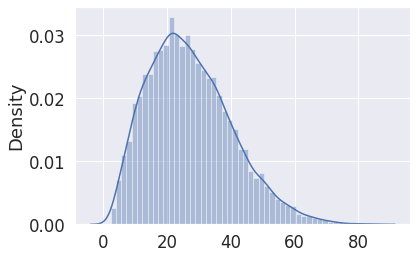

In [5]:
dist = scipy.stats.rayleigh(loc=2, scale=20)
rvs = dist.rvs(10000)
sns.distplot(rvs)

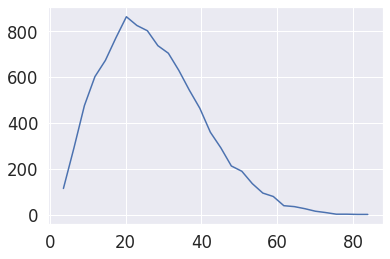

In [6]:
# need to make a callable function of the histogram of this. 
h, b = np.histogram(rvs, 30)
b = tb.bin_edges_to_center(b)
plt.plot(b, h)

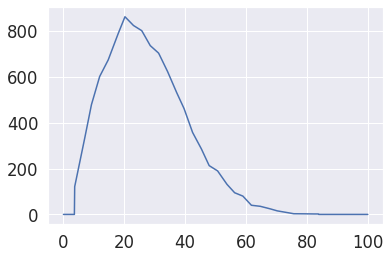

In [7]:
f = scipy.interpolate.interp1d(b,h, bounds_error=False, fill_value=0)
XX = np.linspace(0, 100, 1000)
plt.plot(XX, f(XX))


In [9]:
from theano.tensor import _shared

# @theano.as_op(itypes=[theano.tensor.dscalar],otypes=[theano.tensor.dscalar])
def dens_fn(x):
    return tt.log(f(x) )
# dens_fn(_shared(np.linspace(-1, 5, 10)))

In [10]:
with pm.Model() as model:
    dens = pm.DensityDist('density', logp=dens_fn)
    trace = pm.sample(5000)
    

ValueError: object arrays are not supported

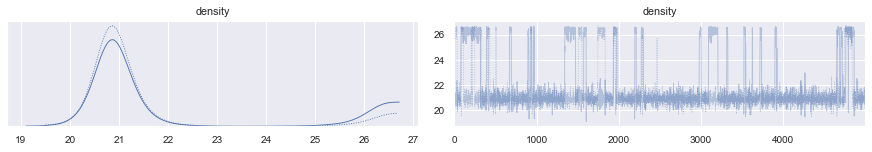

In [10]:
pm.traceplot(trace);

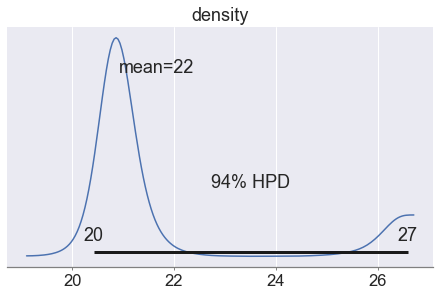

In [11]:
pm.plot_posterior(trace);